In [1]:
"""
Exploratory Data Analysis (EDA) for YOLO Road Damage Detection Dataset
=======================================================================
Complete analysis pipeline for Federated Learning system preparation
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter
import pandas as pd
from PIL import Image
import random
import json
from tqdm import tqdm

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:

# ============================================================================
# CONFIGURATION
# ============================================================================

DATASET_ROOT = Path("Pothole.v1i.yolov8")
TRAIN_IMAGES = DATASET_ROOT / "train" / "images"
TRAIN_LABELS = DATASET_ROOT / "train" / "labels"
VALID_IMAGES = DATASET_ROOT / "valid" / "images"
VALID_LABELS = DATASET_ROOT / "valid" / "labels"
TEST_IMAGES = DATASET_ROOT / "test" / "images"
TEST_LABELS = DATASET_ROOT / "test" / "labels"

CLASS_NAMES = ['banner', 'erosion', 'hcrack', 'pothole', 'stone', 'trash', 'vcrack']
NUM_CLASSES = 7

OUTPUT_DIR = Path("eda_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("="*80)
print("YOLO ROAD DAMAGE DETECTION - EXPLORATORY DATA ANALYSIS")
print("="*80)
print(f"\nDataset Root: {DATASET_ROOT}")
print(f"Classes: {CLASS_NAMES}")
print(f"Number of Classes: {NUM_CLASSES}\n")

YOLO ROAD DAMAGE DETECTION - EXPLORATORY DATA ANALYSIS

Dataset Root: Pothole.v1i.yolov8
Classes: ['banner', 'erosion', 'hcrack', 'pothole', 'stone', 'trash', 'vcrack']
Number of Classes: 7



In [8]:

SAMPLE_LIMIT = 5        # sample limit for image/label checks
SHOW_EXAMPLES = 5        # how many example missing/errors to print

# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("1. DATASET INTEGRITY CHECK")
print("="*80 + "\n")

def check_dataset_integrity(image_dir: Path, label_dir: Path, split_name: str):
    """Check integrity of image-label pairs and YOLO format compliance"""
    results = {
        'split': split_name,
        'total_images': 0,
        'total_labels': 0,
        'matched_pairs': 0,
        'missing_labels': [],
        'missing_images': [],
        'corrupted_images': [],
        'invalid_labels': [],
        'format_errors': []
    }

    if not image_dir.exists() or not label_dir.exists():
        print(f"Warning: {split_name} directories not found! ({image_dir}, {label_dir})")
        return results

    # Get all image and label files
    image_files = {f.stem: f for f in image_dir.glob("*") if f.suffix.lower() in ['.jpg', '.jpeg', '.png']}
    label_files = {f.stem: f for f in label_dir.glob("*.txt")}

    results['total_images'] = len(image_files)
    results['total_labels'] = len(label_files)

    print(f"{split_name.upper()} Split:")
    print(f"  Images found: {results['total_images']}")
    print(f"  Labels found: {results['total_labels']}")

    # Check for missing labels
    for img_stem in image_files:
        if img_stem not in label_files:
            results['missing_labels'].append(img_stem)

    # Check for missing images
    for lbl_stem in label_files:
        if lbl_stem not in image_files:
            results['missing_images'].append(lbl_stem)

    # Matched pairs
    results['matched_pairs'] = len(set(image_files.keys()) & set(label_files.keys()))

    # Verify image integrity (sample)
    print(f"  Checking image integrity (sampling up to {SAMPLE_LIMIT})...")
    for img_stem, img_path in tqdm(list(image_files.items())[:min(SAMPLE_LIMIT, len(image_files))], desc="    Images"):
        try:
            img = cv2.imread(str(img_path))
            if img is None:
                results['corrupted_images'].append(str(img_path))
        except Exception:
            results['corrupted_images'].append(str(img_path))

    # Verify YOLO format compliance (sample)
    print(f"  Checking YOLO label format (sampling up to {SAMPLE_LIMIT})...")
    for lbl_stem, lbl_path in tqdm(list(label_files.items())[:min(SAMPLE_LIMIT, len(label_files))], desc="    Labels"):
        try:
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
                for line_num, line in enumerate(lines, 1):
                    line = line.strip()
                    if not line:
                        continue

                    parts = line.split()
                    if len(parts) != 5:
                        results['format_errors'].append(f"{lbl_path}:L{line_num} - Wrong number of values ({len(parts)})")
                        continue

                    try:
                        cls_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])

                        # Check class ID
                        if cls_id < 0 or cls_id >= NUM_CLASSES:
                            results['format_errors'].append(f"{lbl_path}:L{line_num} - Invalid class {cls_id}")

                        # Check normalized coordinates [0, 1]
                        if not (0.0 <= x_center <= 1.0 and 0.0 <= y_center <= 1.0 and 0.0 <= width <= 1.0 and 0.0 <= height <= 1.0):
                            results['format_errors'].append(f"{lbl_path}:L{line_num} - Coords out of [0,1] range ({x_center}, {y_center}, {width}, {height})")

                    except ValueError:
                        results['format_errors'].append(f"{lbl_path}:L{line_num} - Non-numeric values")
        except Exception as e:
            results['invalid_labels'].append(f"{lbl_path}: {str(e)}")

    # Summary print for this split
    print(f"\n  Summary for {split_name}:")
    print(f"    Matched pairs:      {results['matched_pairs']}")
    print(f"    Missing labels:     {len(results['missing_labels'])}")
    print(f"    Missing images:     {len(results['missing_images'])}")
    print(f"    Corrupted images:   {len(results['corrupted_images'])}")
    print(f"    Format errors:      {len(results['format_errors'])}")
    print(f"    Invalid label files:{len(results['invalid_labels'])}\n")

    return results

# Run integrity checks
integrity_results = {}
integrity_results['train'] = check_dataset_integrity(TRAIN_IMAGES, TRAIN_LABELS, 'train')
integrity_results['valid'] = check_dataset_integrity(VALID_IMAGES, VALID_LABELS, 'valid')
integrity_results['test']  = check_dataset_integrity(TEST_IMAGES, TEST_LABELS, 'test')

# Print full consolidated report
print("\n" + "="*80)
print("CONSOLIDATED INTEGRITY REPORT")
print("="*80 + "\n")

for split, results in integrity_results.items():
    print(f"{split.upper()} SPLIT:")
    print(f"  Total Images:    {results['total_images']}")
    print(f"  Total Labels:    {results['total_labels']}")
    print(f"  Matched Pairs:   {results['matched_pairs']}")
    print(f"  Missing Labels:  {len(results['missing_labels'])}")
    if results['missing_labels']:
        print(f"    Example missing label stems (up to {SHOW_EXAMPLES}):")
        for item in results['missing_labels'][:SHOW_EXAMPLES]:
            print(f"      - {item}")
    print(f"  Missing Images:  {len(results['missing_images'])}")
    if results['missing_images']:
        print(f"    Example missing image label stems (up to {SHOW_EXAMPLES}):")
        for item in results['missing_images'][:SHOW_EXAMPLES]:
            print(f"      - {item}")
    print(f"  Corrupted Images: {len(results['corrupted_images'])}")
    if results['corrupted_images']:
        print(f"    Example corrupted images (up to {SHOW_EXAMPLES}):")
        for item in results['corrupted_images'][:SHOW_EXAMPLES]:
            print(f"      - {item}")
    print(f"  Format Errors:   {len(results['format_errors'])}")
    if results['format_errors']:
        print(f"    Example format errors (up to {SHOW_EXAMPLES}):")
        for item in results['format_errors'][:SHOW_EXAMPLES]:
            print(f"      - {item}")
    print(f"  Invalid Label Files: {len(results['invalid_labels'])}")
    if results['invalid_labels']:
        print(f"    Example invalid label file errors (up to {SHOW_EXAMPLES}):")
        for item in results['invalid_labels'][:SHOW_EXAMPLES]:
            print(f"      - {item}")
    print("-"*80)

# Final summary
total_images_all = sum(r['total_images'] for r in integrity_results.values())
total_labels_all = sum(r['total_labels'] for r in integrity_results.values())
total_matched = sum(r['matched_pairs'] for r in integrity_results.values())

print("\nOVERALL SUMMARY:")
print(f"  Total images (all splits): {total_images_all}")
print(f"  Total label files (all splits): {total_labels_all}")
print(f"  Total matched pairs (all splits): {total_matched}")
print("\nIntegrity check complete.")



1. DATASET INTEGRITY CHECK

TRAIN Split:
  Images found: 1429
  Labels found: 1429
  Checking image integrity (sampling up to 5)...


    Images:   0%|          | 0/5 [00:00<?, ?it/s]

    Images: 100%|██████████| 5/5 [00:00<00:00, 90.95it/s]


  Checking YOLO label format (sampling up to 5)...


    Labels: 100%|██████████| 5/5 [00:00<00:00, 2037.65it/s]



  Summary for train:
    Matched pairs:      1429
    Missing labels:     0
    Missing images:     0
    Corrupted images:   0
    Format errors:      0
    Invalid label files:0

VALID Split:
  Images found: 393
  Labels found: 393
  Checking image integrity (sampling up to 5)...


    Images: 100%|██████████| 5/5 [00:00<00:00, 172.15it/s]


  Checking YOLO label format (sampling up to 5)...


    Labels: 100%|██████████| 5/5 [00:00<00:00, 4950.78it/s]



  Summary for valid:
    Matched pairs:      393
    Missing labels:     0
    Missing images:     0
    Corrupted images:   0
    Format errors:      0
    Invalid label files:0

TEST Split:
  Images found: 182
  Labels found: 182
  Checking image integrity (sampling up to 5)...


    Images: 100%|██████████| 5/5 [00:00<00:00, 152.22it/s]


  Checking YOLO label format (sampling up to 5)...


    Labels: 100%|██████████| 5/5 [00:00<00:00, 4722.25it/s]


  Summary for test:
    Matched pairs:      182
    Missing labels:     0
    Missing images:     0
    Corrupted images:   0
    Format errors:      0
    Invalid label files:0


CONSOLIDATED INTEGRITY REPORT

TRAIN SPLIT:
  Total Images:    1429
  Total Labels:    1429
  Matched Pairs:   1429
  Missing Labels:  0
  Missing Images:  0
  Corrupted Images: 0
  Format Errors:   0
  Invalid Label Files: 0
--------------------------------------------------------------------------------
VALID SPLIT:
  Total Images:    393
  Total Labels:    393
  Matched Pairs:   393
  Missing Labels:  0
  Missing Images:  0
  Corrupted Images: 0
  Format Errors:   0
  Invalid Label Files: 0
--------------------------------------------------------------------------------
TEST SPLIT:
  Total Images:    182
  Total Labels:    182
  Matched Pairs:   182
  Missing Labels:  0
  Missing Images:  0
  Corrupted Images: 0
  Format Errors:   0
  Invalid Label Files: 0
------------------------------------------------

In [10]:

# ============================================================================
# 2. ANNOTATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("2. ANNOTATION ANALYSIS")
print("="*80)

def parse_annotations(label_dir, image_dir):
    """Parse all annotations and extract statistics"""
    
    stats = {
        'class_counts': Counter(),
        'boxes_per_image': [],
        'box_areas': [],
        'box_widths': [],
        'box_heights': [],
        'box_aspect_ratios': [],
        'annotations': defaultdict(list),
        'total_annotations': 0
    }
    
    label_files = list(label_dir.glob("*.txt"))
    
    for lbl_path in tqdm(label_files, desc="  Parsing annotations"):
        img_stem = lbl_path.stem
        img_path = None
        
        # Find corresponding image
        for ext in ['.jpg', '.jpeg', '.png']:
            potential_path = image_dir / f"{img_stem}{ext}"
            if potential_path.exists():
                img_path = potential_path
                break
        
        if not img_path:
            continue
        
        boxes_in_image = 0
        
        try:
            with open(lbl_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    
                    parts = line.split()
                    if len(parts) != 5:
                        continue
                    
                    cls_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    stats['class_counts'][cls_id] += 1
                    stats['box_areas'].append(width * height)
                    stats['box_widths'].append(width)
                    stats['box_heights'].append(height)
                    stats['box_aspect_ratios'].append(width / height if height > 0 else 0)
                    stats['annotations'][img_stem].append((cls_id, x_center, y_center, width, height))
                    stats['total_annotations'] += 1
                    boxes_in_image += 1
            
            stats['boxes_per_image'].append(boxes_in_image)
        
        except Exception as e:
            continue
    
    return stats

# Parse annotations for train and valid
print("\nParsing TRAIN annotations...")
train_stats = parse_annotations(TRAIN_LABELS, TRAIN_IMAGES)

print("\nParsing VALID annotations...")
valid_stats = parse_annotations(VALID_LABELS, VALID_IMAGES)

# Print statistics
print(f"\n📊 Annotation Statistics:")
print(f"\nTRAIN:")
print(f"  Total annotations: {train_stats['total_annotations']}")
print(f"  Images with annotations: {len(train_stats['boxes_per_image'])}")
print(f"  Avg boxes per image: {np.mean(train_stats['boxes_per_image']):.2f}")
print(f"  Max boxes per image: {max(train_stats['boxes_per_image']) if train_stats['boxes_per_image'] else 0}")

print(f"\nVALID:")
print(f"  Total annotations: {valid_stats['total_annotations']}")
print(f"  Images with annotations: {len(valid_stats['boxes_per_image'])}")
print(f"  Avg boxes per image: {np.mean(valid_stats['boxes_per_image']):.2f}")
print(f"  Max boxes per image: {max(valid_stats['boxes_per_image']) if valid_stats['boxes_per_image'] else 0}")



2. ANNOTATION ANALYSIS

Parsing TRAIN annotations...


  Parsing annotations: 100%|██████████| 1429/1429 [00:00<00:00, 18809.36it/s]



Parsing VALID annotations...


  Parsing annotations: 100%|██████████| 393/393 [00:00<00:00, 16230.74it/s]


📊 Annotation Statistics:

TRAIN:
  Total annotations: 3162
  Images with annotations: 1429
  Avg boxes per image: 2.21
  Max boxes per image: 13

VALID:
  Total annotations: 904
  Images with annotations: 393
  Avg boxes per image: 2.30
  Max boxes per image: 13



3. CLASS DISTRIBUTION ANALYSIS
✓ Saved: eda_outputs/class_distribution.png

📊 Class Imbalance Analysis:
  Most common class: vcrack (2808 samples)
  Least common class: trash (26 samples)
  Imbalance ratio: 108.00x
  ⚠️  SEVERE imbalance detected! Consider:
     - Class weights in loss function
     - Data augmentation for minority classes
     - Focal loss or similar techniques


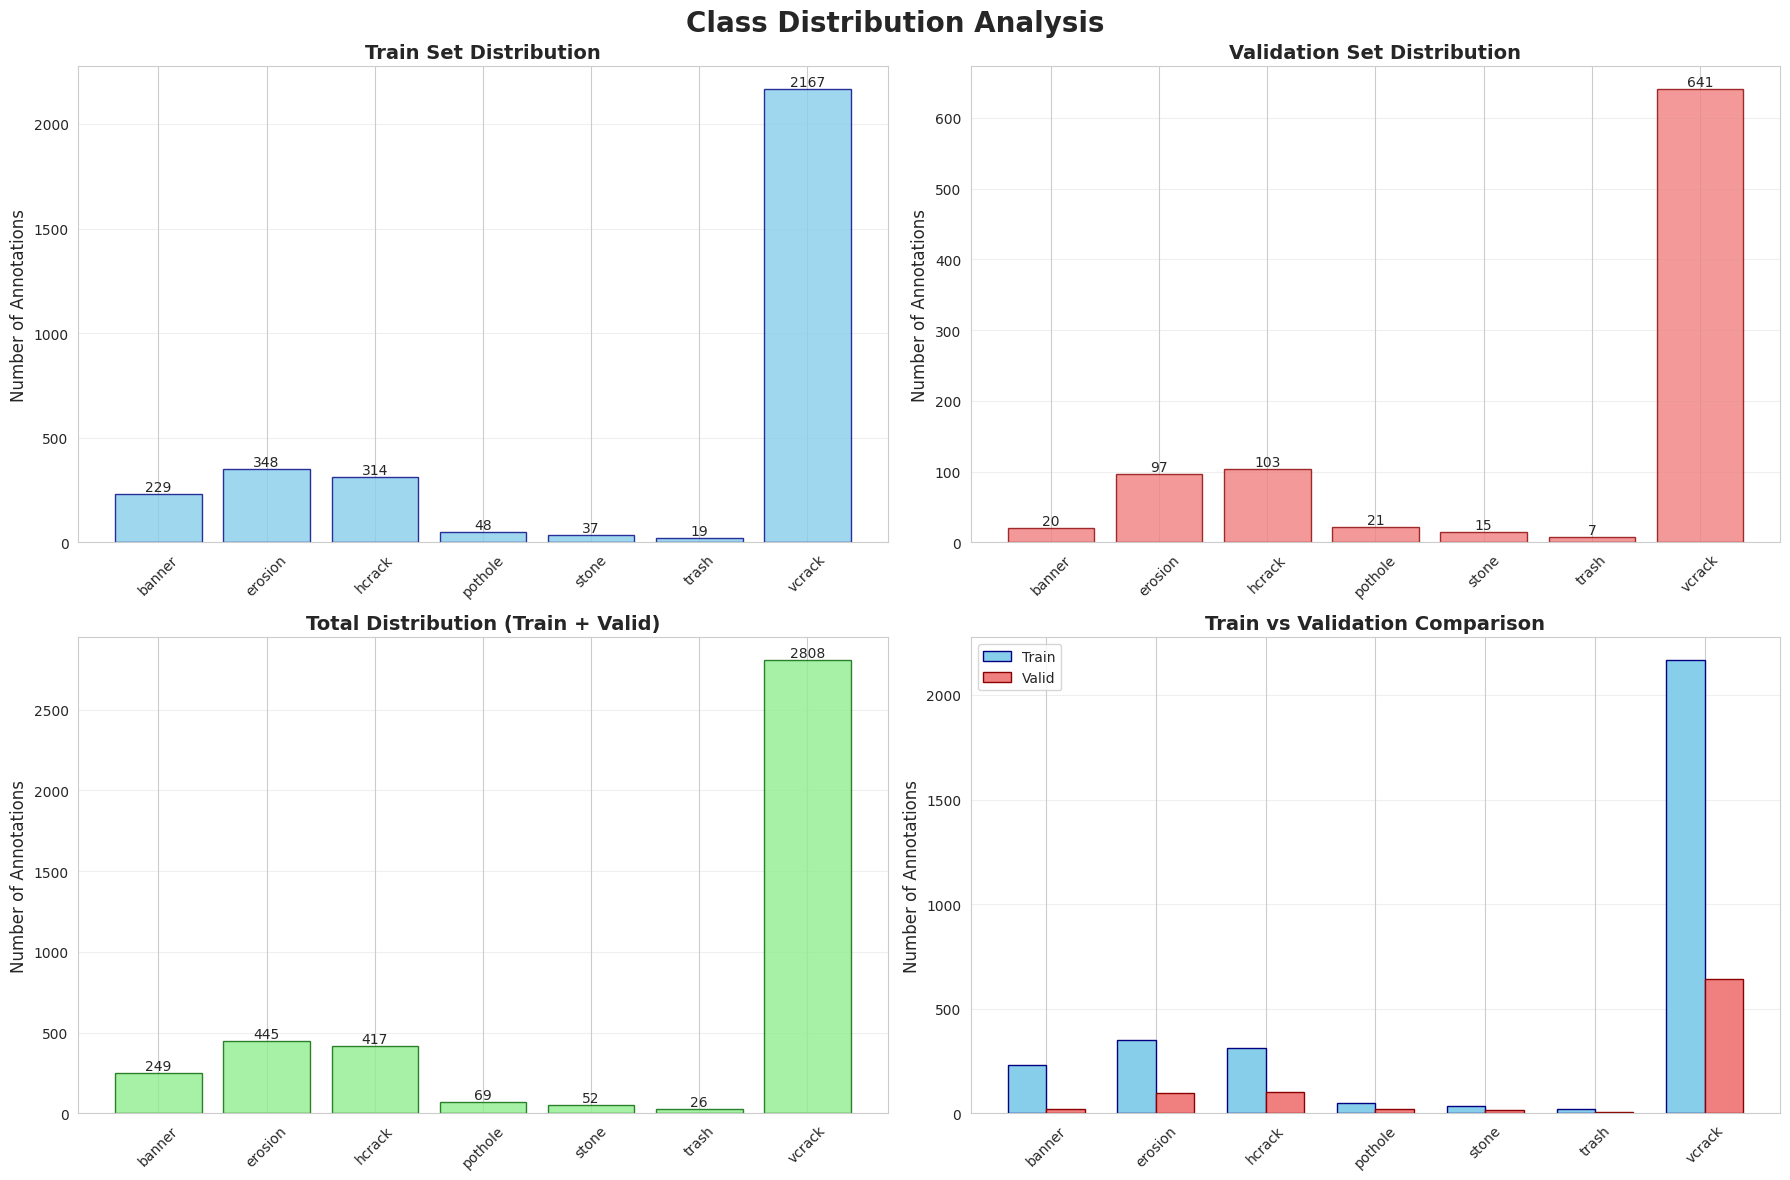

In [11]:

# ============================================================================
# 3. CLASS DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("3. CLASS DISTRIBUTION ANALYSIS")
print("="*80)

def plot_class_distribution(train_counts, valid_counts, class_names):
    """Create comprehensive class distribution visualizations"""
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Class Distribution Analysis', fontsize=20, fontweight='bold')
    
    # Prepare data
    train_data = [train_counts.get(i, 0) for i in range(len(class_names))]
    valid_data = [valid_counts.get(i, 0) for i in range(len(class_names))]
    total_data = [train_data[i] + valid_data[i] for i in range(len(class_names))]
    
    # 1. Train distribution
    ax1 = axes[0, 0]
    bars1 = ax1.bar(class_names, train_data, color='skyblue', edgecolor='navy', alpha=0.8)
    ax1.set_title('Train Set Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Annotations', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # 2. Validation distribution
    ax2 = axes[0, 1]
    bars2 = ax2.bar(class_names, valid_data, color='lightcoral', edgecolor='darkred', alpha=0.8)
    ax2.set_title('Validation Set Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Annotations', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # 3. Combined distribution
    ax3 = axes[1, 0]
    bars3 = ax3.bar(class_names, total_data, color='lightgreen', edgecolor='darkgreen', alpha=0.8)
    ax3.set_title('Total Distribution (Train + Valid)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Number of Annotations', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(axis='y', alpha=0.3)
    
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # 4. Comparison - Stacked bar chart
    ax4 = axes[1, 1]
    x = np.arange(len(class_names))
    width = 0.35
    
    bars_train = ax4.bar(x - width/2, train_data, width, label='Train', color='skyblue', edgecolor='navy')
    bars_valid = ax4.bar(x + width/2, valid_data, width, label='Valid', color='lightcoral', edgecolor='darkred')
    
    ax4.set_title('Train vs Validation Comparison', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Number of Annotations', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels(class_names, rotation=45)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / 'class_distribution.png'}")
    
    return total_data

total_distribution = plot_class_distribution(
    train_stats['class_counts'],
    valid_stats['class_counts'],
    CLASS_NAMES
)

# Analyze class imbalance
print("\n📊 Class Imbalance Analysis:")
max_count = max(total_distribution)
min_count = min([c for c in total_distribution if c > 0], default=0)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"  Most common class: {CLASS_NAMES[total_distribution.index(max_count)]} ({max_count} samples)")
print(f"  Least common class: {CLASS_NAMES[total_distribution.index(min_count)]} ({min_count} samples)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 10:
    print("  ⚠️  SEVERE imbalance detected! Consider:")
    print("     - Class weights in loss function")
    print("     - Data augmentation for minority classes")
    print("     - Focal loss or similar techniques")



4. BOUNDING BOX ANALYSIS
✓ Saved: eda_outputs/train_bbox_analysis.png
✓ Saved: eda_outputs/valid_bbox_analysis.png

Bounding Box Statistics (TRAIN):
  Mean area: 0.0108
  Mean width: 0.0970
  Mean height: 0.1010
  Mean aspect ratio: 1.5902


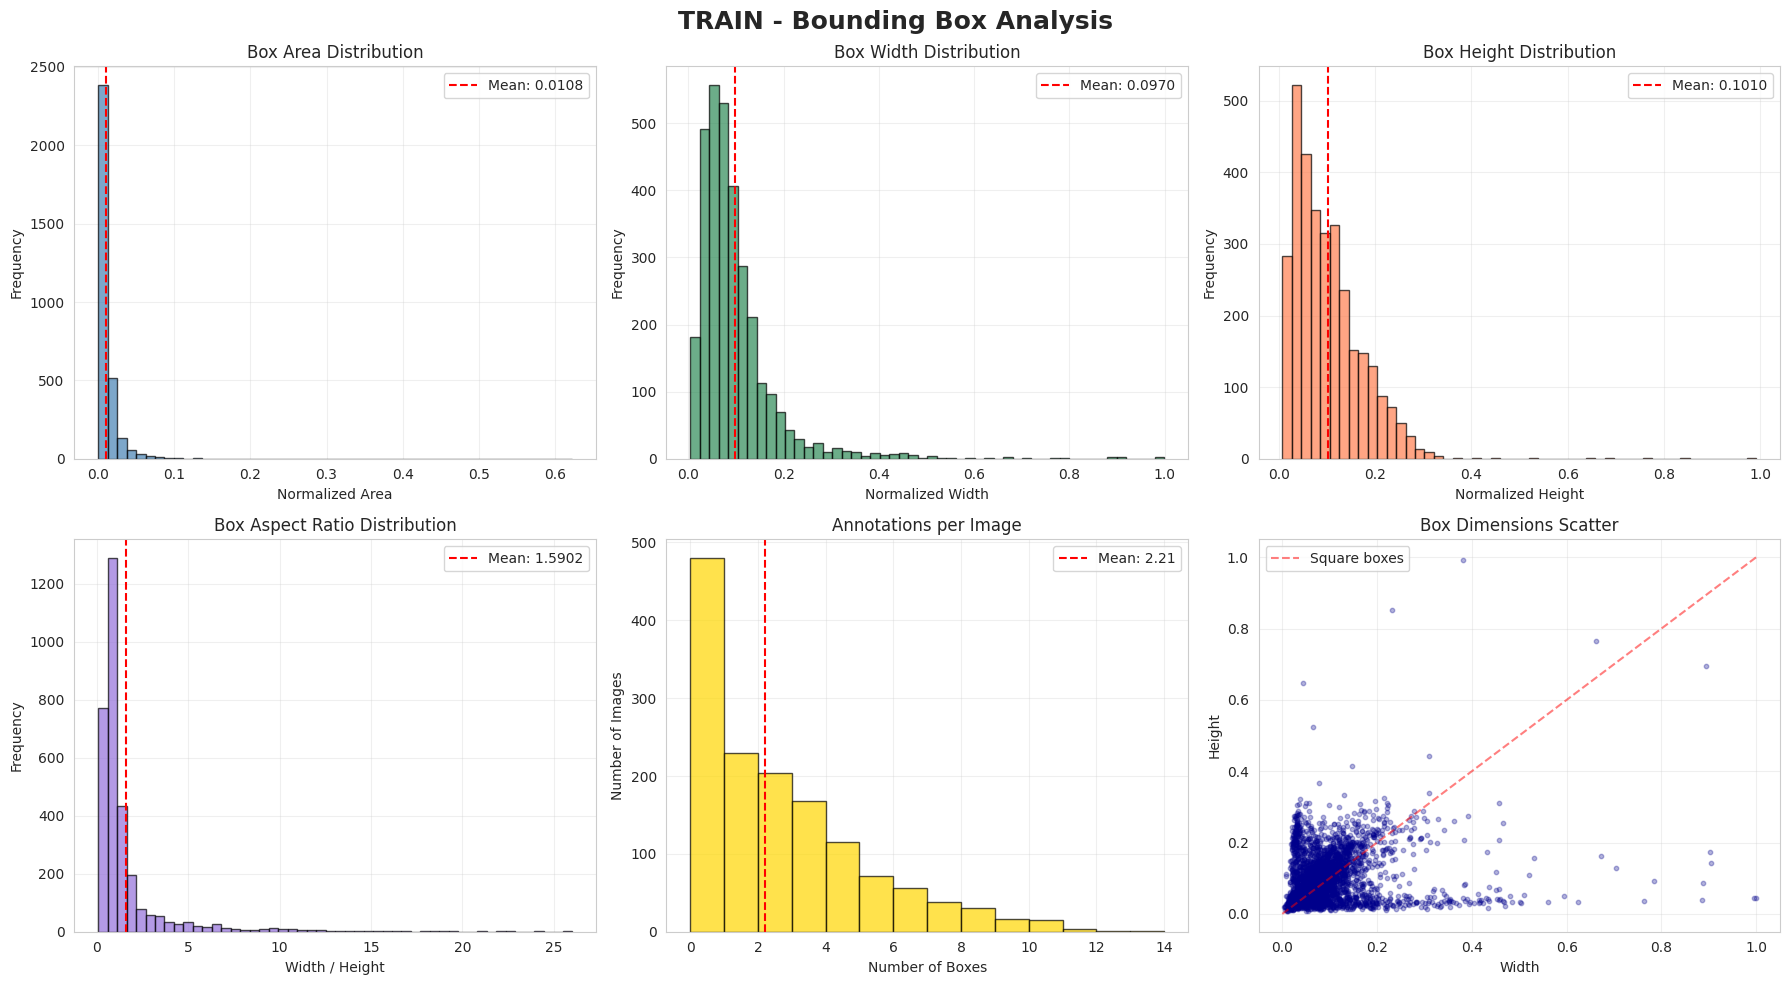

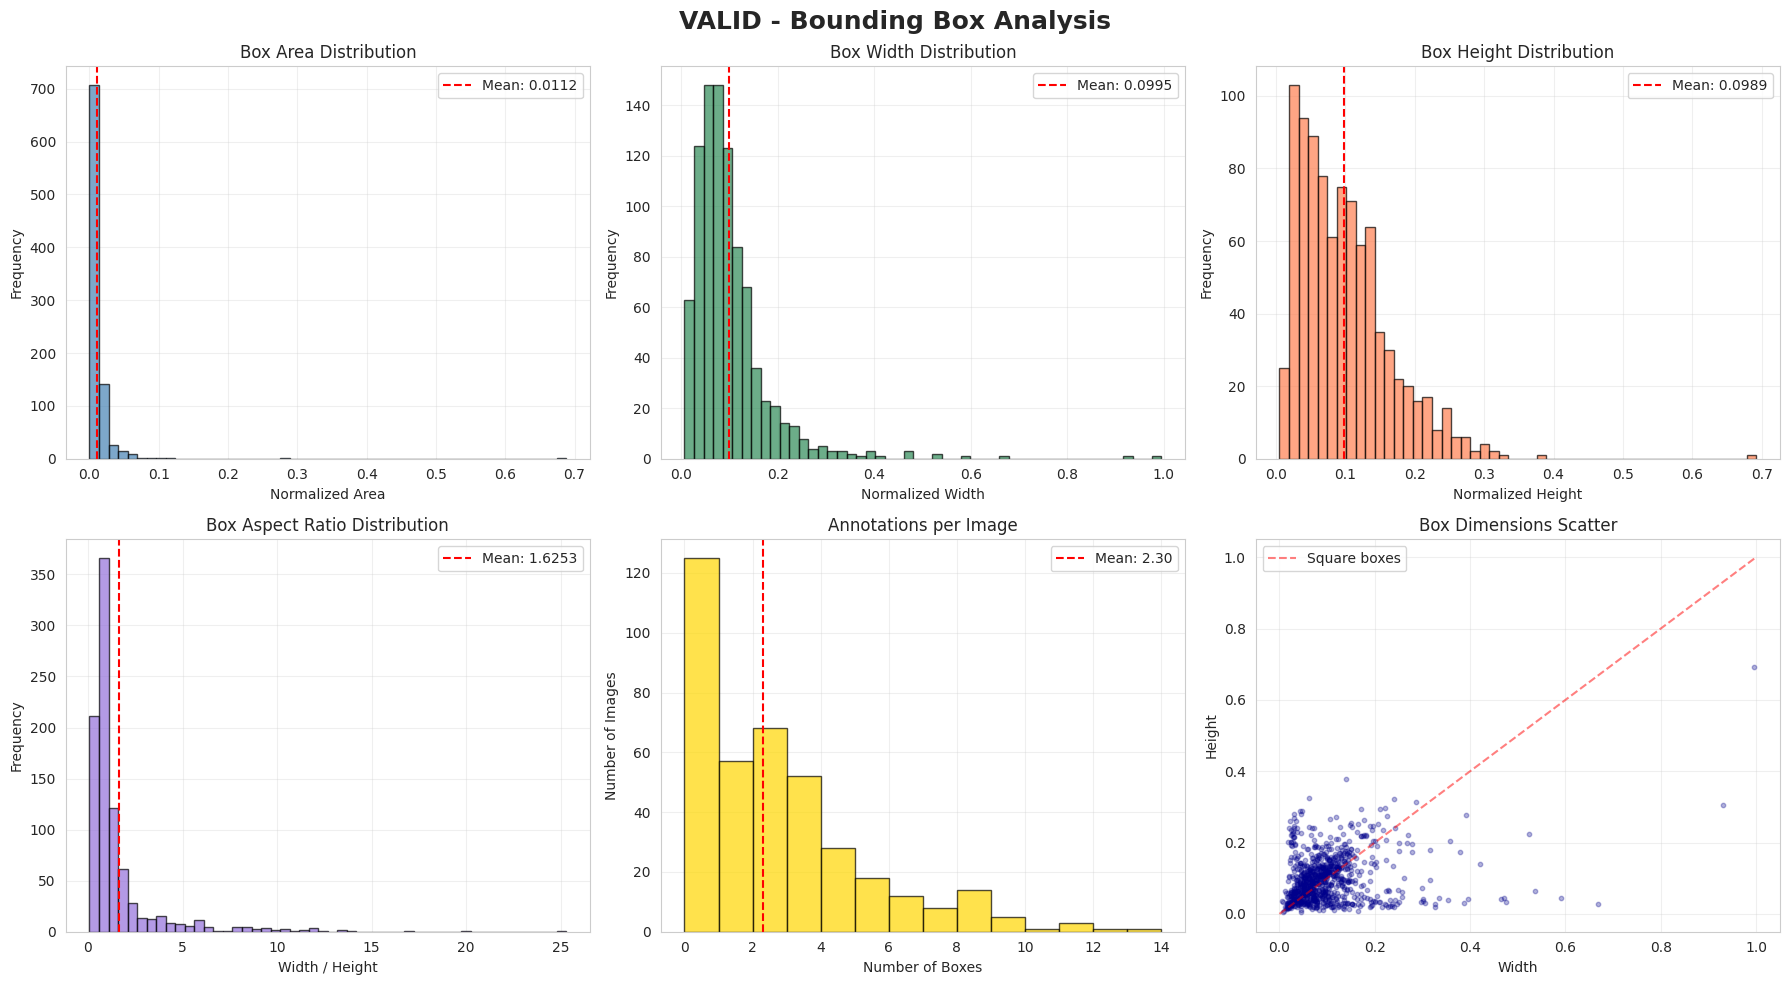

In [12]:

# ============================================================================
# 4. BOUNDING BOX ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. BOUNDING BOX ANALYSIS")
print("="*80)

def plot_bbox_statistics(stats, title_prefix):
    """Plot bounding box size and distribution statistics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{title_prefix} - Bounding Box Analysis', fontsize=18, fontweight='bold')
    
    # 1. Box area distribution
    ax1 = axes[0, 0]
    ax1.hist(stats['box_areas'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_title('Box Area Distribution')
    ax1.set_xlabel('Normalized Area')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(stats['box_areas']), color='red', linestyle='--', label=f'Mean: {np.mean(stats["box_areas"]):.4f}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. Box width distribution
    ax2 = axes[0, 1]
    ax2.hist(stats['box_widths'], bins=50, color='seagreen', edgecolor='black', alpha=0.7)
    ax2.set_title('Box Width Distribution')
    ax2.set_xlabel('Normalized Width')
    ax2.set_ylabel('Frequency')
    ax2.axvline(np.mean(stats['box_widths']), color='red', linestyle='--', label=f'Mean: {np.mean(stats["box_widths"]):.4f}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # 3. Box height distribution
    ax3 = axes[0, 2]
    ax3.hist(stats['box_heights'], bins=50, color='coral', edgecolor='black', alpha=0.7)
    ax3.set_title('Box Height Distribution')
    ax3.set_xlabel('Normalized Height')
    ax3.set_ylabel('Frequency')
    ax3.axvline(np.mean(stats['box_heights']), color='red', linestyle='--', label=f'Mean: {np.mean(stats["box_heights"]):.4f}')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # 4. Aspect ratio distribution
    ax4 = axes[1, 0]
    ax4.hist(stats['box_aspect_ratios'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
    ax4.set_title('Box Aspect Ratio Distribution')
    ax4.set_xlabel('Width / Height')
    ax4.set_ylabel('Frequency')
    ax4.axvline(np.mean(stats['box_aspect_ratios']), color='red', linestyle='--', label=f'Mean: {np.mean(stats["box_aspect_ratios"]):.4f}')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # 5. Boxes per image
    ax5 = axes[1, 1]
    ax5.hist(stats['boxes_per_image'], bins=range(0, max(stats['boxes_per_image'])+2), 
             color='gold', edgecolor='black', alpha=0.7)
    ax5.set_title('Annotations per Image')
    ax5.set_xlabel('Number of Boxes')
    ax5.set_ylabel('Number of Images')
    ax5.axvline(np.mean(stats['boxes_per_image']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(stats["boxes_per_image"]):.2f}')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # 6. Box size scatter (width vs height)
    ax6 = axes[1, 2]
    ax6.scatter(stats['box_widths'], stats['box_heights'], alpha=0.3, s=10, color='darkblue')
    ax6.set_title('Box Dimensions Scatter')
    ax6.set_xlabel('Width')
    ax6.set_ylabel('Height')
    ax6.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Square boxes')
    ax6.legend()
    ax6.grid(alpha=0.3)
    
    plt.tight_layout()
    filename = f"{title_prefix.lower().replace(' ', '_')}_bbox_analysis.png"
    plt.savefig(OUTPUT_DIR / filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR / filename}")

plot_bbox_statistics(train_stats, 'TRAIN')
plot_bbox_statistics(valid_stats, 'VALID')

# Print bbox statistics
print(f"\nBounding Box Statistics (TRAIN):")
print(f"  Mean area: {np.mean(train_stats['box_areas']):.4f}")
print(f"  Mean width: {np.mean(train_stats['box_widths']):.4f}")
print(f"  Mean height: {np.mean(train_stats['box_heights']):.4f}")
print(f"  Mean aspect ratio: {np.mean(train_stats['box_aspect_ratios']):.4f}")



5. IMAGE RESOLUTION & METADATA ANALYSIS


  Analyzing valid images: 100%|██████████| 200/200 [00:00<00:00, 9151.97it/s]


✓ Saved: eda_outputs/resolution_analysis.png

📐 Resolution Statistics:

TRAIN:
  Width: 1280 - 1280 (mean: 1280)
  Height: 720 - 720 (mean: 720)
  Aspect ratio: 1.78 - 1.78
  File size: 65.6 - 148.9 KB

VALID:
  Width: 1280 - 1280 (mean: 1280)
  Height: 720 - 720 (mean: 720)
  Aspect ratio: 1.78 - 1.78
  File size: 67.0 - 152.4 KB


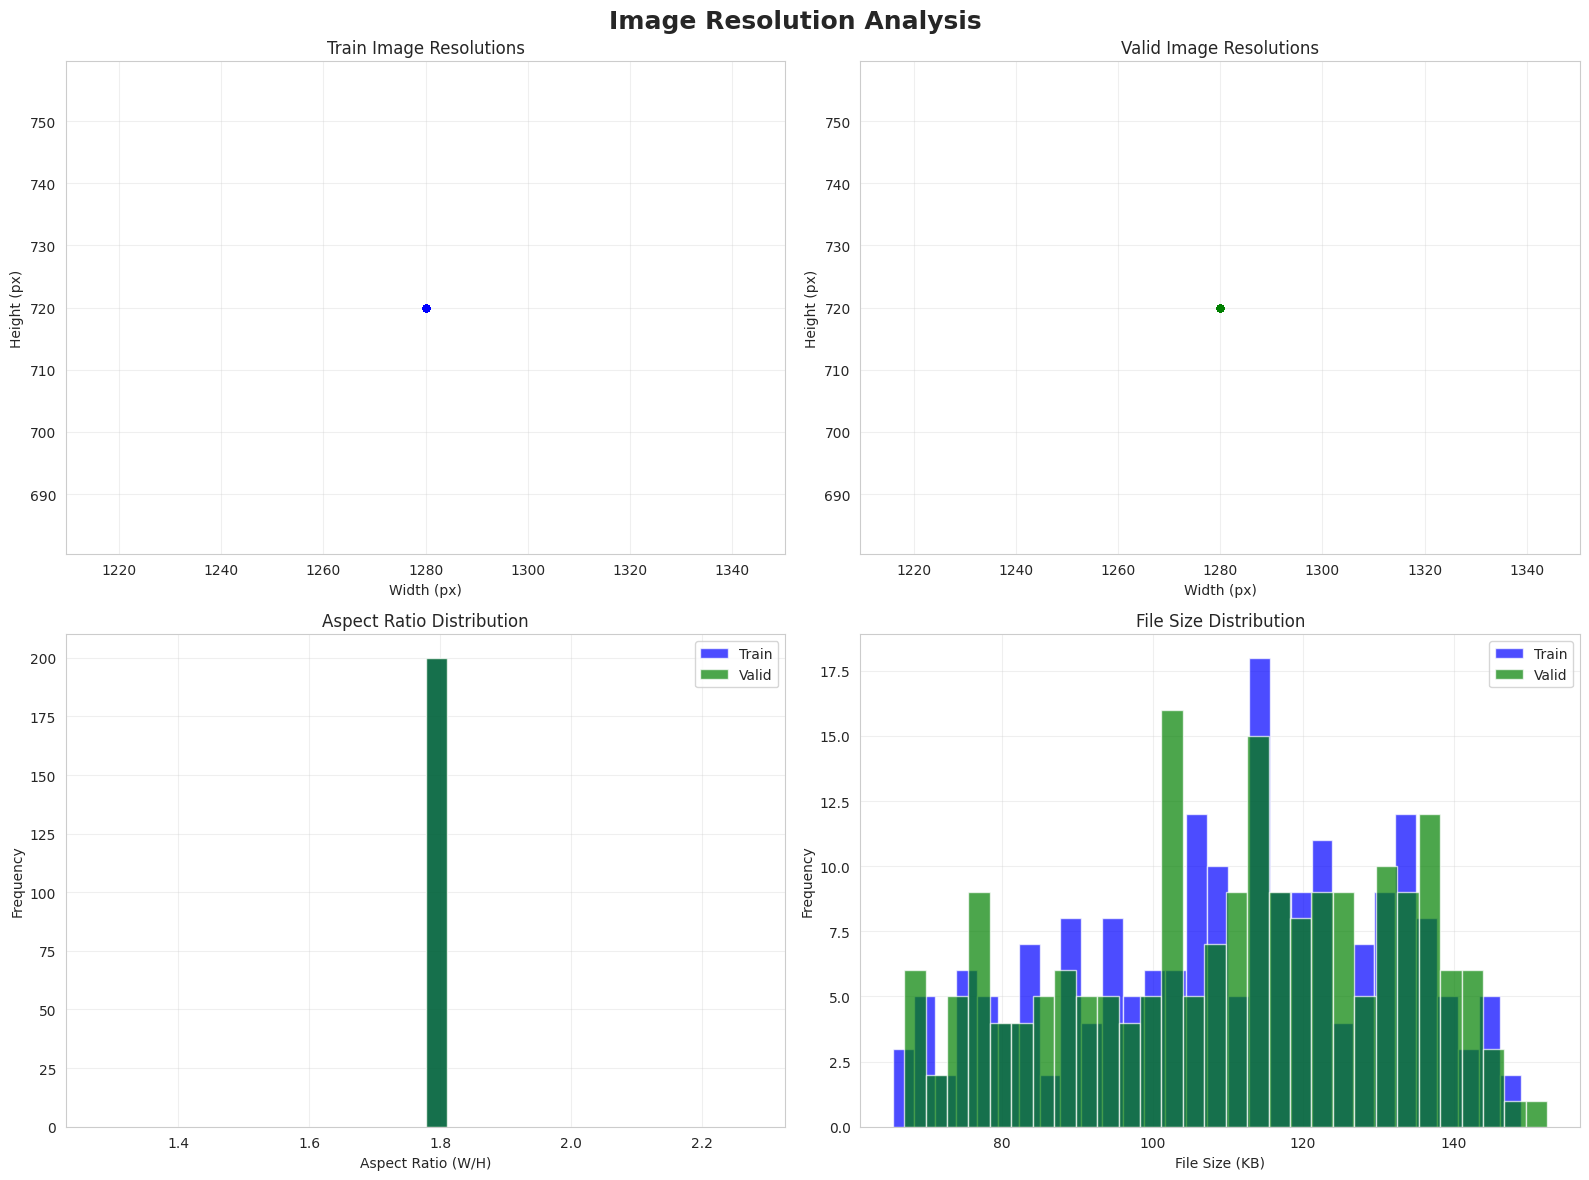

In [13]:

# ============================================================================
# 5. IMAGE RESOLUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("5. IMAGE RESOLUTION & METADATA ANALYSIS")
print("="*80)

def analyze_image_properties(image_dir, split_name, sample_size=200):
    """Analyze image resolutions and properties"""
    
    image_files = list(image_dir.glob("*"))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if len(image_files) > sample_size:
        image_files = random.sample(image_files, sample_size)
    
    properties = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'file_sizes': [],
        'formats': Counter()
    }
    
    for img_path in tqdm(image_files, desc=f"  Analyzing {split_name} images"):
        try:
            img = Image.open(img_path)
            w, h = img.size
            
            properties['widths'].append(w)
            properties['heights'].append(h)
            properties['aspect_ratios'].append(w / h if h > 0 else 0)
            properties['file_sizes'].append(img_path.stat().st_size / 1024)  # KB
            properties['formats'][img.format] += 1
            
        except Exception as e:
            continue
    
    return properties

train_props = analyze_image_properties(TRAIN_IMAGES, 'train')
valid_props = analyze_image_properties(VALID_IMAGES, 'valid')

# Plot resolution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Image Resolution Analysis', fontsize=18, fontweight='bold')

# Train resolution scatter
ax1 = axes[0, 0]
ax1.scatter(train_props['widths'], train_props['heights'], alpha=0.5, s=20, color='blue')
ax1.set_title('Train Image Resolutions')
ax1.set_xlabel('Width (px)')
ax1.set_ylabel('Height (px)')
ax1.grid(alpha=0.3)

# Valid resolution scatter
ax2 = axes[0, 1]
ax2.scatter(valid_props['widths'], valid_props['heights'], alpha=0.5, s=20, color='green')
ax2.set_title('Valid Image Resolutions')
ax2.set_xlabel('Width (px)')
ax2.set_ylabel('Height (px)')
ax2.grid(alpha=0.3)

# Aspect ratio histogram
ax3 = axes[1, 0]
ax3.hist(train_props['aspect_ratios'], bins=30, alpha=0.7, label='Train', color='blue')
ax3.hist(valid_props['aspect_ratios'], bins=30, alpha=0.7, label='Valid', color='green')
ax3.set_title('Aspect Ratio Distribution')
ax3.set_xlabel('Aspect Ratio (W/H)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(alpha=0.3)

# File size distribution
ax4 = axes[1, 1]
ax4.hist(train_props['file_sizes'], bins=30, alpha=0.7, label='Train', color='blue')
ax4.hist(valid_props['file_sizes'], bins=30, alpha=0.7, label='Valid', color='green')
ax4.set_title('File Size Distribution')
ax4.set_xlabel('File Size (KB)')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'resolution_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR / 'resolution_analysis.png'}")

print(f"\n📐 Resolution Statistics:")
print(f"\nTRAIN:")
print(f"  Width: {np.min(train_props['widths']):.0f} - {np.max(train_props['widths']):.0f} (mean: {np.mean(train_props['widths']):.0f})")
print(f"  Height: {np.min(train_props['heights']):.0f} - {np.max(train_props['heights']):.0f} (mean: {np.mean(train_props['heights']):.0f})")
print(f"  Aspect ratio: {np.min(train_props['aspect_ratios']):.2f} - {np.max(train_props['aspect_ratios']):.2f}")
print(f"  File size: {np.min(train_props['file_sizes']):.1f} - {np.max(train_props['file_sizes']):.1f} KB")

print(f"\nVALID:")
print(f"  Width: {np.min(valid_props['widths']):.0f} - {np.max(valid_props['widths']):.0f} (mean: {np.mean(valid_props['widths']):.0f})")
print(f"  Height: {np.min(valid_props['heights']):.0f} - {np.max(valid_props['heights']):.0f} (mean: {np.mean(valid_props['heights']):.0f})")
print(f"  Aspect ratio: {np.min(valid_props['aspect_ratios']):.2f} - {np.max(valid_props['aspect_ratios']):.2f}")
print(f"  File size: {np.min(valid_props['file_sizes']):.1f} - {np.max(valid_props['file_sizes']):.1f} KB")


In [14]:

# ============================================================================
# 6. SAMPLE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("6. SAMPLE VISUALIZATION WITH ANNOTATIONS")
print("="*80)

def draw_bbox_on_image(img, boxes, class_names):
    """Draw bounding boxes on image"""
    h, w = img.shape[:2]
    
    # Color palette for classes
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0),
        (255, 0, 255), (0, 255, 255), (128, 0, 128)
    ]
    
    for cls_id, x_center, y_center, width, height in boxes:
        # Convert normalized to pixel coordinates
        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        x2 = int((x_center + width/2) * w)
        y2 = int((y_center + height/2) * h)
        
        color = colors[cls_id % len(colors)]
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        
        # Draw label
        label = class_names[cls_id]
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x1, y1 - label_size[1] - 10), (x1 + label_size[0], y1), color, -1)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    return img

def visualize_samples(image_dir, annotations, class_names, num_samples=20):
    """Visualize random samples with annotations"""
    
    # Get random samples
    available_stems = list(annotations.keys())
    if len(available_stems) > num_samples:
        available_stems = random.sample(available_stems, num_samples)
    
    # Try to get samples from all classes
    class_coverage = {i: [] for i in range(len(class_names))}
    for stem in available_stems:
        for cls_id, _, _, _, _ in annotations[stem]:
            class_coverage[cls_id].append(stem)
    
    # Ensure at least one sample per class if possible
    final_samples = set()
    for cls_id, stems in class_coverage.items():
        if stems and len(final_samples) < num_samples:
            final_samples.add(random.choice(stems))
    
    # Fill remaining slots
    while len(final_samples) < num_samples and len(final_samples) < len(available_stems):
        final_samples.add(random.choice(available_stems))
    
    final_samples = list(final_samples)[:num_samples]
    
    # Create grid for visualization
    n_cols = 5
    n_rows = (len(final_samples) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
    fig.suptitle('Sample Images with Annotations', fontsize=20, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, stem in enumerate(final_samples):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        # Find image file
        img_path = None
        for ext in ['.jpg', '.jpeg', '.png']:
            potential = image_dir / f"{stem}{ext}"
            if potential.exists():
                img_path = potential
                break
        
        if img_path is None:
            ax.axis('off')
            continue
        
        # Load and draw
        img = cv2.imread(str(img_path))
        if img is None:
            ax.axis('off')
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_annotated = draw_bbox_on_image(img.copy(), annotations[stem], class_names)
        
        ax.imshow(img_annotated)
        ax.set_title(f"{stem[:20]}...\n{len(annotations[stem])} boxes", fontsize=9)
        ax.axis('off')
    
    # Hide empty subplots
    for idx in range(len(final_samples), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    return fig

# Visualize train samples
print("\n📸 Visualizing TRAIN samples...")
fig_train = visualize_samples(TRAIN_IMAGES, train_stats['annotations'], CLASS_NAMES, num_samples=20)
plt.savefig(OUTPUT_DIR / 'train_samples.png', dpi=200, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR / 'train_samples.png'}")
plt.close()

# Visualize validation samples
print("📸 Visualizing VALID samples...")
fig_valid = visualize_samples(VALID_IMAGES, valid_stats['annotations'], CLASS_NAMES, num_samples=20)
plt.savefig(OUTPUT_DIR / 'valid_samples.png', dpi=200, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR / 'valid_samples.png'}")
plt.close()



6. SAMPLE VISUALIZATION WITH ANNOTATIONS

📸 Visualizing TRAIN samples...
✓ Saved: eda_outputs/train_samples.png
📸 Visualizing VALID samples...
✓ Saved: eda_outputs/valid_samples.png


In [15]:


# ============================================================================
# 7. SUMMARY REPORT
# ============================================================================

print("\n" + "="*80)
print("7. GENERATING COMPREHENSIVE SUMMARY REPORT")
print("="*80)

summary_report = f"""
{'='*80}
EXPLORATORY DATA ANALYSIS - SUMMARY REPORT
Road Damage Detection Dataset for Federated Learning
{'='*80}

DATASET OVERVIEW
{'='*80}
Classes: {CLASS_NAMES}
Number of Classes: {NUM_CLASSES}

DATASET SPLITS:
  Train Images:      {integrity_results['train']['total_images']}
  Train Labels:      {integrity_results['train']['total_labels']}
  Valid Images:      {integrity_results['valid']['total_images']}
  Valid Labels:      {integrity_results['valid']['total_labels']}
  Test Images:       {integrity_results['test']['total_images']}
  Test Labels:       {integrity_results['test']['total_labels']}

INTEGRITY CHECK RESULTS
{'='*80}
TRAIN:
  ✓ Matched pairs: {integrity_results['train']['matched_pairs']}
  ⚠ Missing labels: {len(integrity_results['train']['missing_labels'])}
  ⚠ Missing images: {len(integrity_results['train']['missing_images'])}
  ⚠ Corrupted images: {len(integrity_results['train']['corrupted_images'])}
  ⚠ Format errors: {len(integrity_results['train']['format_errors'])}

VALID:
  ✓ Matched pairs: {integrity_results['valid']['matched_pairs']}
  ⚠ Missing labels: {len(integrity_results['valid']['missing_labels'])}
  ⚠ Missing images: {len(integrity_results['valid']['missing_images'])}
  ⚠ Corrupted images: {len(integrity_results['valid']['corrupted_images'])}
  ⚠ Format errors: {len(integrity_results['valid']['format_errors'])}

TEST:
  ✓ Matched pairs: {integrity_results['test']['matched_pairs']}
  ⚠ Missing labels: {len(integrity_results['test']['missing_labels'])}
  ⚠ Missing images: {len(integrity_results['test']['missing_images'])}
  ⚠ Corrupted images: {len(integrity_results['test']['corrupted_images'])}
  ⚠ Format errors: {len(integrity_results['test']['format_errors'])}

ANNOTATION STATISTICS
{'='*80}
TRAIN:
  Total annotations: {train_stats['total_annotations']}
  Images with annotations: {len(train_stats['boxes_per_image'])}
  Avg boxes per image: {np.mean(train_stats['boxes_per_image']):.2f}
  Max boxes per image: {max(train_stats['boxes_per_image']) if train_stats['boxes_per_image'] else 0}
  Min boxes per image: {min(train_stats['boxes_per_image']) if train_stats['boxes_per_image'] else 0}

VALID:
  Total annotations: {valid_stats['total_annotations']}
  Images with annotations: {len(valid_stats['boxes_per_image'])}
  Avg boxes per image: {np.mean(valid_stats['boxes_per_image']):.2f}
  Max boxes per image: {max(valid_stats['boxes_per_image']) if valid_stats['boxes_per_image'] else 0}
  Min boxes per image: {min(valid_stats['boxes_per_image']) if valid_stats['boxes_per_image'] else 0}

CLASS DISTRIBUTION
{'='*80}
"""

for i, class_name in enumerate(CLASS_NAMES):
    train_count = train_stats['class_counts'].get(i, 0)
    valid_count = valid_stats['class_counts'].get(i, 0)
    total_count = train_count + valid_count
    percentage = (total_count / (train_stats['total_annotations'] + valid_stats['total_annotations'])) * 100
    summary_report += f"{class_name:12} | Train: {train_count:6} | Valid: {valid_count:6} | Total: {total_count:6} | {percentage:5.2f}%\n"

max_count = max(total_distribution)
min_count = min([c for c in total_distribution if c > 0], default=0)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

summary_report += f"""
CLASS IMBALANCE:
  Most common: {CLASS_NAMES[total_distribution.index(max_count)]} ({max_count} samples)
  Least common: {CLASS_NAMES[total_distribution.index(min_count)]} ({min_count} samples)
  Imbalance ratio: {imbalance_ratio:.2f}x
"""

if imbalance_ratio > 10:
    summary_report += "\n  ⚠️ SEVERE IMBALANCE DETECTED!\n"

summary_report += f"""

BOUNDING BOX STATISTICS
{'='*80}
TRAIN:
  Mean box area: {np.mean(train_stats['box_areas']):.4f}
  Mean box width: {np.mean(train_stats['box_widths']):.4f}
  Mean box height: {np.mean(train_stats['box_heights']):.4f}
  Mean aspect ratio: {np.mean(train_stats['box_aspect_ratios']):.4f}
  
  Box area range: {np.min(train_stats['box_areas']):.4f} - {np.max(train_stats['box_areas']):.4f}
  Box width range: {np.min(train_stats['box_widths']):.4f} - {np.max(train_stats['box_widths']):.4f}
  Box height range: {np.min(train_stats['box_heights']):.4f} - {np.max(train_stats['box_heights']):.4f}

VALID:
  Mean box area: {np.mean(valid_stats['box_areas']):.4f}
  Mean box width: {np.mean(valid_stats['box_widths']):.4f}
  Mean box height: {np.mean(valid_stats['box_heights']):.4f}
  Mean aspect ratio: {np.mean(valid_stats['box_aspect_ratios']):.4f}

IMAGE PROPERTIES
{'='*80}
TRAIN (sampled):
  Width range: {np.min(train_props['widths']):.0f} - {np.max(train_props['widths']):.0f} px (mean: {np.mean(train_props['widths']):.0f})
  Height range: {np.min(train_props['heights']):.0f} - {np.max(train_props['heights']):.0f} px (mean: {np.mean(train_props['heights']):.0f})
  Aspect ratio: {np.min(train_props['aspect_ratios']):.2f} - {np.max(train_props['aspect_ratios']):.2f}
  File size: {np.min(train_props['file_sizes']):.1f} - {np.max(train_props['file_sizes']):.1f} KB (mean: {np.mean(train_props['file_sizes']):.1f})

VALID (sampled):
  Width range: {np.min(valid_props['widths']):.0f} - {np.max(valid_props['widths']):.0f} px (mean: {np.mean(valid_props['widths']):.0f})
  Height range: {np.min(valid_props['heights']):.0f} - {np.max(valid_props['heights']):.0f} px (mean: {np.mean(valid_props['heights']):.0f})
  Aspect ratio: {np.min(valid_props['aspect_ratios']):.2f} - {np.max(valid_props['aspect_ratios']):.2f}
  File size: {np.min(valid_props['file_sizes']):.1f} - {np.max(valid_props['file_sizes']):.1f} KB (mean: {np.mean(valid_props['file_sizes']):.1f})

QUALITY ISSUES DETECTED
{'='*80}
"""

issues_found = False
if len(integrity_results['train']['missing_labels']) > 0:
    summary_report += f"⚠️ {len(integrity_results['train']['missing_labels'])} images in TRAIN without labels\n"
    issues_found = True
if len(integrity_results['valid']['missing_labels']) > 0:
    summary_report += f"⚠️ {len(integrity_results['valid']['missing_labels'])} images in VALID without labels\n"
    issues_found = True
if len(integrity_results['train']['corrupted_images']) > 0:
    summary_report += f"⚠️ {len(integrity_results['train']['corrupted_images'])} corrupted images in TRAIN\n"
    issues_found = True
if len(integrity_results['train']['format_errors']) > 0:
    summary_report += f"⚠️ {len(integrity_results['train']['format_errors'])} format errors in TRAIN labels\n"
    issues_found = True

if not issues_found:
    summary_report += "✓ No critical issues detected!\n"

summary_report += f"""

RECOMMENDATIONS FOR TRAINING
{'='*80}
"""

recommendations = []

# Check for imbalance
if imbalance_ratio > 10:
    recommendations.append("1. CLASS IMBALANCE: Use class weights in loss function or apply data augmentation")
    recommendations.append("   Suggested weights: " + str({CLASS_NAMES[i]: max_count/total_distribution[i] if total_distribution[i] > 0 else 1.0 for i in range(len(CLASS_NAMES))}))

# Check for small boxes
small_box_threshold = 0.01
small_boxes_train = sum(1 for area in train_stats['box_areas'] if area < small_box_threshold)
if small_boxes_train > len(train_stats['box_areas']) * 0.1:
    recommendations.append(f"2. SMALL OBJECTS: {small_boxes_train} boxes < {small_box_threshold} area. Consider:")
    recommendations.append("   - Multi-scale training")
    recommendations.append("   - Feature Pyramid Networks (FPN)")
    recommendations.append("   - Mosaic augmentation")

# Check resolution variance
if np.std(train_props['widths']) > 200 or np.std(train_props['heights']) > 200:
    recommendations.append("3. RESOLUTION VARIANCE: High variance in image sizes detected")
    recommendations.append(f"   - Standardize to common size (e.g., 640x640 for YOLO)")
    recommendations.append("   - Use appropriate padding/resizing strategy")

# Federated learning specific
recommendations.append("4. FEDERATED LEARNING PREPARATION:")
recommendations.append("   - Split dataset across nodes considering class distribution")
recommendations.append("   - Ensure each node has sufficient samples (min 50-100 images)")
recommendations.append("   - Consider IID vs Non-IID splits based on research goals")
recommendations.append("   - Implement proper data privacy measures")

# Data quality
if issues_found:
    recommendations.append("5. DATA CLEANING:")
    recommendations.append("   - Remove or fix corrupted images/labels")
    recommendations.append("   - Ensure all images have corresponding labels")
    recommendations.append("   - Validate YOLO format compliance")

if recommendations:
    for rec in recommendations:
        summary_report += rec + "\n"
else:
    summary_report += "✓ Dataset appears ready for training!\n"

summary_report += f"""

GENERATED OUTPUTS
{'='*80}
The following files have been generated in '{OUTPUT_DIR}/':
  
  1. integrity_report.txt          - Detailed integrity check results
  2. class_distribution.png        - Class distribution visualizations
  3. train_bbox_analysis.png       - Train bounding box statistics
  4. valid_bbox_analysis.png       - Valid bounding box statistics
  5. resolution_analysis.png       - Image resolution analysis
  6. train_samples.png             - Sample annotated images (train)
  7. valid_samples.png             - Sample annotated images (valid)
  8. eda_summary.txt               - This summary report

NEXT STEPS
{'='*80}
1. Review all generated visualizations and reports
2. Address any quality issues identified
3. Prepare data.yaml configuration file
4. Plan federated learning data split strategy
5. Set up federated_base/ directory
6. Configure training hyperparameters based on findings

{'='*80}
EDA COMPLETE - Dataset ready for Phase 1 deliverables
{'='*80}
"""

# Save summary report
with open(OUTPUT_DIR / 'eda_summary.txt', 'w') as f:
    f.write(summary_report)

print(summary_report)
print(f"\n✓ Summary report saved to {OUTPUT_DIR / 'eda_summary.txt'}")



7. GENERATING COMPREHENSIVE SUMMARY REPORT

EXPLORATORY DATA ANALYSIS - SUMMARY REPORT
Road Damage Detection Dataset for Federated Learning

DATASET OVERVIEW
Classes: ['banner', 'erosion', 'hcrack', 'pothole', 'stone', 'trash', 'vcrack']
Number of Classes: 7

DATASET SPLITS:
  Train Images:      1429
  Train Labels:      1429
  Valid Images:      393
  Valid Labels:      393
  Test Images:       182
  Test Labels:       182

INTEGRITY CHECK RESULTS
TRAIN:
  ✓ Matched pairs: 1429
  ⚠ Missing labels: 0
  ⚠ Missing images: 0
  ⚠ Corrupted images: 0
  ⚠ Format errors: 0

VALID:
  ✓ Matched pairs: 393
  ⚠ Missing labels: 0
  ⚠ Missing images: 0
  ⚠ Corrupted images: 0
  ⚠ Format errors: 0

TEST:
  ✓ Matched pairs: 182
  ⚠ Missing labels: 0
  ⚠ Missing images: 0
  ⚠ Corrupted images: 0
  ⚠ Format errors: 0

ANNOTATION STATISTICS
TRAIN:
  Total annotations: 3162
  Images with annotations: 1429
  Avg boxes per image: 2.21
  Max boxes per image: 13
  Min boxes per image: 0

VALID:
  Total anno